Spectral Clustering code example from ChatGPT

In [7]:
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn.datasets import make_blobs
from sklearn.neighbors import kneighbors_graph
from scipy.linalg import expm
import matplotlib.pyplot as plt

# Generate synthetic 2D data
np.random.seed(42)
X, y = make_blobs(n_samples=300, centers=3, cluster_std=0.70, random_state=0)

# Create the affinity matrix using Euclidean distance
affinity_matrix = kneighbors_graph(X, n_neighbors=10, mode='connectivity', metric='euclidean', include_self=True)

# Compute the similarity matrix using the exponential of the negative squared distances
similarity_matrix = np.exp(-0.5 * affinity_matrix.power(2).toarray())

# Apply Spectral Clustering
n_clusters = 3  # Number of clusters
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
labels = spectral.fit_predict(X)

# Plot the results
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.title("Spectral Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


AttributeError: 'NoneType' object has no attribute 'split'

Example code from [sklean](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html)


/var/folders/nz/nc2qx3kj6pdfmzbqlfjgln900000gn/T/ipykernel_58985/153683358.py:13: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X2 = np.random.multivariate_normal([4, 4], cov2, size=200)


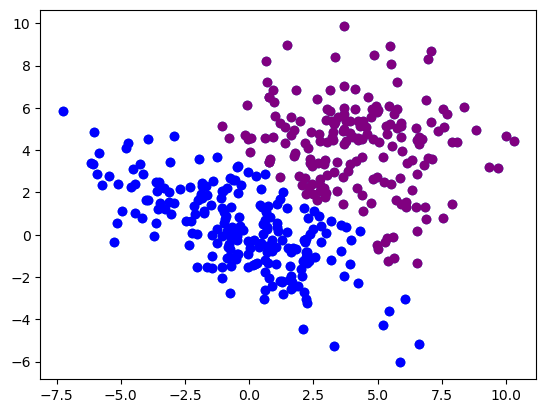

In [40]:
from sklearn.cluster import SpectralClustering
import numpy as np
import matplotlib.pyplot as plt 
import random

#X = np.array([[1, 1], [2, 1], [1, 0],
#              [4, 7], [3, 5], [3, 6]])

cov1 = np.array([[6, -3], [-3, 3.5]])
X1 = np.random.multivariate_normal([0, 0], cov1, size=200)
cov2 = np.array([[0, 5], [5, 0]])
X2 = np.random.multivariate_normal([4, 4], cov2, size=200)
X = np.concatenate((X1, X2))

clustering = SpectralClustering(n_clusters=2,
                                assign_labels='discretize',
                                random_state=0).fit(X)
#print(clustering.labels_)
#array([1, 1, 1, 0, 0, 0])
#clustering
#SpectralClustering(assign_labels='discretize', n_clusters=2, random_state=0)

plt.scatter(X[:, 0], X[:, 1], label = 'Data')
for i in range(len(X)):
    if clustering.labels_[i] == 1:
        plt.scatter(X[i, 0], X[i, 1], c = 'blue')
    else:
        plt.scatter(X[i, 0], X[i, 1], c = 'purple')
plt.show()

